In [359]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import pylab

In [2]:
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
FIGURES_DIR = "figures/mlsys22"

## Simulator accuracy

In [4]:
def get_parallelism_style(dp, hp, pp):
    if dp == 1 and hp == 1 and pp == 1:
        return "Base"
    elif dp > 1 and hp == 1 and pp == 1:
        return "D"
    elif dp == 1 and hp > 1 and pp == 1:
        return "T"
    elif dp == 1 and hp == 1 and pp > 1:
        return "P"
    elif dp > 1 and hp > 1 and pp == 1:
        return "D/T"
    elif dp == 1 and hp > 1 and pp > 1:
        return "T/P"
    elif dp > 1 and hp == 1 and pp > 1:
        return "D/P"
    elif dp > 1 and hp > 1 and pp > 1:
        return "D/T/P"
    else:
        raise ValueError(f"Invalid degree combination dp={dp}, hp={hp}, pp={pp}")

In [685]:
def plot_simulator_accuracy(
    pytorch_filename,
    simulation_filename,
    x,
    y,
    xlabel,
    ylabel,
    xstep,
    ystep,
    output_filename,
    legend_output_filename=None,
):
    plt.rc('xtick', labelsize=24)
    plt.rc('ytick', labelsize=24)
    plt.rc('axes', labelsize=24)
    df_pytorch = pd.read_csv(pytorch_filename)
    df_simulation = pd.read_csv(simulation_filename)
    df_pytorch = df_pytorch.rename(
        columns={
            "latency": "pytorch_latency",
            "throughput": "pytorch_throughput",
            "peak_memory": "pytorch_peak_memory",
        }
    )
    df_simulation = df_simulation.rename(
        columns={
            "latency": "simulated_latency",
            "throughput": "simulated_throughput",
            "peak_memory": "simulated_peak_memory",
        }
    )
    df = pd.merge(left=df_pytorch, right=df_simulation)
    df = df[df["simulated_throughput"] > 0]
    df = df[df["pytorch_throughput"] > 0]
    parallelism_styles = [
        get_parallelism_style(dp, hp, pp)
        for (dp, hp, pp) in df[["dp_degree", "hp_degree", "pp_degree"]].values
    ]
    df["parallelism_style"] = parallelism_styles
    markers = ["o", "P", "^", "*", "X", "D", "H", "s"]
    colors = [
        "#1f77b4",  # muted blue
        "#ff7f0e",  # safety orange
        "#2ca02c",  # cooked asparagus green
        "#d62728",  # brick red
        "#9467bd",  # muted purple
        "#8c564b",  # chestnut brown
        "#e377c2",  # raspberry yogurt pink
        "#7f7f7f",  # middle gray
        # "#bcbd22",  # curry yellow-green
        # "#17becf",  # blue-teal
    ]
    parallelism_styles = [
        "D",
        "T",
        "P",
        "D/T",
        "T/P",
        "D/P",
        "D/T/P",
    ]
    lines = []
    fig = pylab.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    figlegend = pylab.figure(figsize=(5, 1))
    for (parallelism_style, marker, color) in zip(parallelism_styles, markers, colors):
        lines.append(
            ax.scatter(
                df[df["parallelism_style"] == parallelism_style][x],
                df[df["parallelism_style"] == parallelism_style][y],
                label=parallelism_style,
                marker=marker,
                color=color,
                s=100,
                zorder=3,
            )
        )
    m, b = np.polyfit(df[x], df[y], deg=1)
#     min_val = min(min(df[x]), min(df[y]))
#     max_val = max(max(df[x]), max(df[y]))
    ax.plot(
        df[x],
        m * df[x] + b,
#         [min_val, max_val],
#         [min_val, max_val],
        linestyle="--",
        color="black",
        zorder=2,
    )
    #     ax.set_yticks(np.arange(0, max(df[y]) + ystep, ystep))
    #     xticks = np.arange(0, max(df[x]) + xstep, xstep)
    #     yticks = np.arange(0, max(df[x]) + ystep, ystep)
    #     ax.set_xticks(xticks)
    #     ax.set_xticklabels([str(int(t)) for t in xticks])
    #     ax.set_yticks(yticks)
    #     ax.set_yticklabels([str(int(t)) for t in yticks])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(zorder=0)
    leg = figlegend.legend(
        lines,
        parallelism_styles,
        frameon=False,
        loc="center",
        ncol=4,
        columnspacing=None,
        labelspacing=None,
    )
    fig.savefig(output_filename, bbox_inches="tight")
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")
    # Get the bounding box of the original legend.


#     bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())

#     # Change to location of the legend.
#     yOffset = 1.2
#     bb.y0 += yOffset
#     bb.y1 += yOffset
#     leg.set_bbox_to_anchor(bb, transform=plt.gca().transAxes)
#     leg.get_frame().set_linewidth(0.0)

### MLP Training

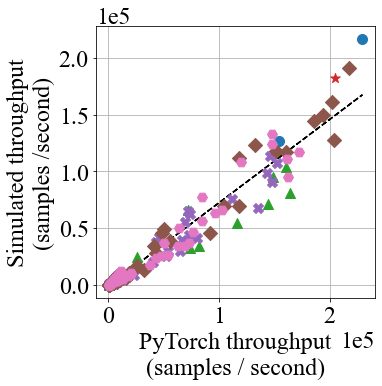

<Figure size 360x72 with 0 Axes>

In [686]:
simulation_filename = "~/Downloads/mlp_dgx_backend_grid_search_results_sample_v2.csv"
pytorch_filename = "~/Downloads/mlp_dgx_simulated_grid_search_results_sample_v2.csv"
plot_simulator_accuracy(
    pytorch_filename,
    simulation_filename,
    "pytorch_throughput",
    "simulated_throughput",
    "PyTorch throughput\n(samples / second)",
    "Simulated throughput\n(samples /second)",
    5000,
    2500,
    os.path.join(FIGURES_DIR, "mlp_training_pytorch_vs_simulated_throughput.pdf"),
    os.path.join(FIGURES_DIR, "pytorch_vs_simulated_throughput_legend.pdf"),
)

### GPT-2 Inference

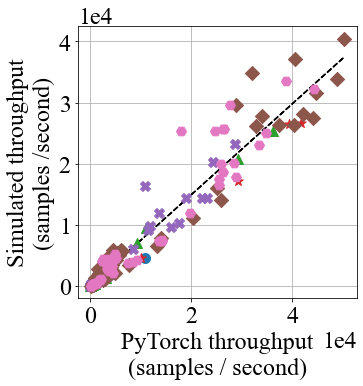

<Figure size 360x72 with 0 Axes>

In [688]:
simulation_filename = "~/Downloads/gpt2_dgx_backend_grid_search_results_sample_v2.csv"
pytorch_filename = "~/Downloads/gpt2_dgx_simulated_grid_search_results_sample_v2.csv"
plot_simulator_accuracy(
    pytorch_filename,
    simulation_filename,
    "pytorch_throughput",
    "simulated_throughput",
    "PyTorch throughput\n(samples / second)",
    "Simulated throughput\n(samples /second)",
    5000,
    2500,
    os.path.join(FIGURES_DIR, "gpt2_inference_pytorch_vs_simulated_throughput.pdf"),
    None,
)

## Optimal configurations

In [852]:
def plot_throughput_vs_batch_size(
    model_size,
    pure_baseline_dp_filename,
    pure_baseline_hp_filename,
    pure_baseline_pp_filename,
    grid_search_simulation_filename,
    grid_search_backend_filename,
    output_filename,
    legend_output_filename=None,
    fixed_batch_size=True,
    max_batch_size=None,
):
    if pure_baseline_dp_filename != "":
        dp_df = pd.read_csv(pure_baseline_dp_filename)
    else:
        dp_df = None
    hp_df = pd.read_csv(pure_baseline_hp_filename)
    pp_df = pd.read_csv(pure_baseline_pp_filename)
    grid_simulation_df = pd.read_csv(grid_search_simulation_filename)
    grid_simulation_df = grid_simulation_df[
        grid_simulation_df["model_size"] == model_size
    ]
    grid_backend_df = pd.read_csv(grid_search_backend_filename)
    grid_backend_df = grid_backend_df[grid_backend_df["model_size"] == model_size]
    grid_simulation_df = grid_simulation_df.rename(
        columns={
            "latency": "simulated_latency",
            "throughput": "simulated_throughput",
            "peak_memory": "simulated_peak_memory",
        }
    )
    grid_backend_df = grid_backend_df.rename(
        columns={
            "latency": "pytorch_latency",
            "throughput": "pytorch_throughput",
            "peak_memory": "pytorch_peak_memory",
        }
    )
    grid_df = pd.merge(grid_simulation_df, grid_backend_df, how="outer")
    grid_df["pytorch_throughput"] = grid_df["pytorch_throughput"].fillna(0)
    all_batch_sizes = [
        set(hp_df["batch_size"].unique()),
        set(pp_df["batch_size"].unique()),
        set(grid_df["batch_size"].unique()),
    ]
    batch_sizes = sorted(
        all_batch_sizes[0].union(all_batch_sizes[1]).union(all_batch_sizes[2])
    )
    batch_sizes = [
        b for b in batch_sizes if max_batch_size is None or b < max_batch_size
    ]
    print(batch_sizes)
    fig = pylab.figure(figsize=(10, 2))
    figlegend = pylab.figure(figsize=(5, 1))
    ax = fig.add_subplot(111)
    markers = ["o", "X", "P", "D"]
    linestyles = ["dotted", "dashed", "dashdot", (0, (1, 1))]
    colors = [
        "#1f77b4",  # muted blue
        "#ff7f0e",  # safety orange
        "#2ca02c",  # cooked asparagus green
        "#d62728",  # brick red
    ]
    markersize = 10
    linewidth = 3
    lines = []

    max_num_trials = -1

    ax.set_xscale("log", base=2)

    def _plot_data(df, batch_sizes, ax, lines, i, label, metric="throughput"):
        x = []
        y = []

        best_configs = []
        for batch_size in batch_sizes:
            if len(df[df["batch_size"] == batch_size]) >= 1:
                throughput = max(df[df["batch_size"] == batch_size][metric])
                if throughput <= 0:
                    continue
                x.append(batch_size)
                y.append(throughput)
                best_config_df = df[
                    (df["batch_size"] == batch_size) & (df[metric] == throughput)
                ]
                assert throughput <= 0.0 or len(best_config_df) == 1
                best_config = (
                    best_config_df["batch_size"].values[0],
                    best_config_df["dp_degree"].values[0],
                    best_config_df["hp_degree"].values[0],
                    best_config_df["pp_degree"].values[0],
                    best_config_df["num_microbatches"].values[0],
                )
                assert best_config[0] == batch_size
                best_configs.append(best_config)
        lines.append(
            ax.plot(
                x,
                y,
                marker=markers[i],
                markersize=markersize,
                linestyle=linestyles[i],
                linewidth=linewidth,
                color=colors[i],
                label=label,
                zorder=3,
            )[0]
        )
        return x, y, best_configs

    dp_x = None
    dp_y = None
    if dp_df is not None:
        dp_x, dp_y, _ = _plot_data(dp_df, batch_sizes, ax, lines, 0, "D")
        max_num_trials = max(max_num_trials, len(dp_df))
    hp_x, hp_y, _ = _plot_data(hp_df, batch_sizes, ax, lines, 1, "T")
    pp_x, pp_y, _ = _plot_data(pp_df, batch_sizes, ax, lines, 2, "P")
    grid_x, grid_y, best_configs = _plot_data(
        grid_df, batch_sizes, ax, lines, 3, "Grid", metric="pytorch_throughput"
    )
    ax.grid(zorder=0)

    if fixed_batch_size:
        for i, batch_size in enumerate(batch_sizes):
            dp_speedup = np.inf
            hp_speedup = np.inf
            pp_speedup = np.inf
            if dp_y is not None and i < len(dp_y):
                assert batch_size == dp_x[i]
                if i >= len(grid_y):
                    dp_speedup = -1
                else:
                    dp_speedup = grid_y[i] / dp_y[i]
            if i < len(hp_y):
                assert batch_size == hp_x[i]
                if i >= len(grid_y):
                    hp_speedup = -1
                else:
                    hp_speedup = grid_y[i] / hp_y[i]
            if i < len(pp_y):
                assert batch_size == pp_x[i]
                if i >= len(grid_y):
                    pp_speedup = -1
                else:
                    pp_speedup = grid_y[i] / pp_y[i]
            if i < len(best_configs):
                best_config = best_configs[i]
                if batch_size != best_config[0]:
                    print(batch_size)
                    print()
                    print(best_configs)
                    print()
                    print(best_config)
                assert batch_size == best_config[0]
            else:
                continue
            dp_speedup_str = (
                f"{dp_speedup:.1f}$\\times$" if dp_speedup != np.inf else "-"
            )
            hp_speedup_str = (
                f"{hp_speedup:.1f}$\\times$" if hp_speedup != np.inf else "-"
            )
            pp_speedup_str = (
                f"{pp_speedup:.1f}$\\times$" if pp_speedup != np.inf else "-"
            )
            print(
                f"& {batch_size} & "
                f"{best_config[1]}\ /\ {best_config[2]}\ /\ {best_config[3]}\ /\ {best_config[4]} & "
                f"{dp_speedup_str} & {hp_speedup_str} & {pp_speedup_str} \\\\"
            )
    #             print(
    #                 f"batch_size={batch_size}, "
    #                 f"dp_speedup={dp_speedup:.1f}x, "
    #                 f"hp_speedup={hp_speedup:.1f}x, "
    #                 f"pp_speedup={pp_speedup:.1f}x, "
    #                 f"best_config={best_config}"
    #             )
    else:
        dp_speedup = np.inf
        hp_speedup = np.inf
        pp_speedup = np.inf
        j = grid_y.index(max(grid_y))
        if dp_y is not None:
            i = dp_y.index(max(dp_y))
            if i >= len(grid_y):
                dp_speedup = -1
            else:
                dp_speedup = grid_y[j] / dp_y[i]

        i = hp_y.index(max(hp_y))
        if i >= len(grid_y):
            hp_speedup = -1
        else:
            hp_speedup = grid_y[j] / hp_y[i]

        i = pp_y.index(max(pp_y))
        if i >= len(grid_y):
            pp_speedup = -1
        else:
            pp_speedup = grid_y[j] / pp_y[i]

        best_config = best_configs[j]
        dp_speedup_str = f"{dp_speedup:.1f}$\\times$" if dp_speedup != np.inf else "-"
        hp_speedup_str = f"{hp_speedup:.1f}$\\times$" if hp_speedup != np.inf else "-"
        pp_speedup_str = f"{pp_speedup:.1f}$\\times$" if pp_speedup != np.inf else "-"
        print(
            f"& {best_config[0]}\ /\ {best_config[1]}\ /\ {best_config[2]}\ /\ {best_config[3]}\ /\ {best_config[4]} & "
            f"{dp_speedup_str} & {hp_speedup_str} & {pp_speedup_str} \\\\"
        )
    #         print(
    #             f"dp_speedup={dp_speedup:.1f}x, "
    #             f"hp_speedup={hp_speedup:.1f}x, "
    #             f"pp_speedup={pp_speedup:.1f}x, "
    #             f"best_config={best_config}"
    #         )

    class ScalarFormatterForceFormat(ScalarFormatter):
        def _set_format(self):  # Override function that finds format to use.
            self.format = "%1.1f"  # Give format here

    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(yfmt)
    #     ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    #     ax.set_xticks(list(range(batch_sizes)))
    #     ax.set_xticklabels(list(range(1, 1 + max_num_trials)))
    #     ytick_range = np.max(grid_df["cummax_throughput"]) // 4
    #     print(f"ytick_range={ytick_range}")
    #     ax.set_yticks([ytick_range * i for i in range(5)])
    ax.set_xlabel("Batch size")
    ax.set_ylabel("Throughput\n(samples / second)")
    ax.set_ylim(ymin=0)
    leg = figlegend.legend(
        lines,
        ["D", "T", "P", "Grid"],
        frameon=False,
        loc="center",
        ncol=4,
        columnspacing=None,
        labelspacing=None,
    )
    fig.savefig(output_filename, bbox_inches="tight")
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")

In [420]:
def plot_throughput_vs_trials(
    model_size,
    pure_baseline_dp_filename,
    pure_baseline_hp_filename,
    pure_baseline_pp_filename,
    grid_search_simulation_filename,
    grid_search_backend_filename,
    output_filename,
    legend_output_filename=None,
    use_bars=False,
):
    if pure_baseline_dp_filename != "":
        dp_df = pd.read_csv(pure_baseline_dp_filename)
    else:
        dp_df = None
    hp_df = pd.read_csv(pure_baseline_hp_filename)
    pp_df = pd.read_csv(pure_baseline_pp_filename)
    grid_simulation_df = pd.read_csv(grid_search_simulation_filename)
    grid_simulation_df = grid_simulation_df[
        grid_simulation_df["model_size"] == model_size
    ]
    grid_backend_df = pd.read_csv(grid_search_backend_filename)
    grid_backend_df = grid_backend_df[grid_backend_df["model_size"] == model_size]
    grid_simulation_df = grid_simulation_df.rename(
        columns={
            "latency": "simulated_latency",
            "throughput": "simulated_throughput",
            "peak_memory": "simulated_peak_memory",
        }
    )
    grid_backend_df = grid_backend_df.rename(
        columns={
            "latency": "pytorch_latency",
            "throughput": "pytorch_throughput",
            "peak_memory": "pytorch_peak_memory",
        }
    )
    grid_df = pd.merge(grid_simulation_df, grid_backend_df, how="outer")
    grid_df["pytorch_throughput"] = grid_df["pytorch_throughput"].fillna(0)
    if dp_df is not None:
        dp_df["cummax_throughput"] = dp_df["throughput"].cummax()
    hp_df["cummax_throughput"] = hp_df["throughput"].cummax()
    pp_df["cummax_throughput"] = pp_df["throughput"].cummax()
    grid_df["cummax_throughput"] = grid_df["pytorch_throughput"].cummax()
    grid_df[grid_df["cummax_throughput"] == 0] = np.NaN
    fig = pylab.figure(figsize=(10, 2))
    figlegend = pylab.figure(figsize=(5, 1))
    ax = fig.add_subplot(111)
    markers = ["o", "X", "P", "D"]
    linestyles = ["dotted", "dashed", "dashdot", "solid"]
    colors = [
        "#1f77b4",  # muted blue
        "#ff7f0e",  # safety orange
        "#2ca02c",  # cooked asparagus green
        "#d62728",  # brick red
    ]
    markersize = 10
    linewidth = 3
    lines = []
    if use_bars:
        width = 0.16
        offsets = np.array([-3 * width / 2, -width / 2, width / 2, 3 * width / 2])
        if dp_df is not None:
            x = np.array(list(range(len(dp_df)))) + offsets[0]
            ax.bar(x, height=dp_df["cummax_throughput"], width=width, label="D")
        x = np.array(list(range(len(hp_df)))) + offsets[1]
        ax.bar(x, height=hp_df["cummax_throughput"], width=width, label="T")
        x = np.array(list(range(len(pp_df)))) + offsets[2]
        ax.bar(x, height=pp_df["cummax_throughput"], width=width, label="P")
        x = np.array(list(range(len(grid_df)))) + offsets[3]
        ax.bar(x, height=grid_df["cummax_throughput"], width=width, label="Grid")
    else:
        max_num_trials = -1
        if dp_df is not None:
            lines.append(
                ax.plot(
                    list(range(len(dp_df))),
                    dp_df["cummax_throughput"],
                    marker=markers[0],
                    markersize=markersize,
                    linestyle=linestyles[0],
                    linewidth=linewidth,
                    color=colors[0],
                    label="D",
                    zorder=3,
                )[0]
            )
            max_num_trials = max(max_num_trials, len(dp_df))
        lines.append(
            ax.plot(
                list(range(len(hp_df))),
                hp_df["cummax_throughput"],
                marker=markers[1],
                markersize=markersize,
                linestyle=linestyles[1],
                linewidth=linewidth,
                color=colors[1],
                label="T",
                zorder=3,
            )[0]
        )
        max_num_trials = max(max_num_trials, len(hp_df))
        lines.append(
            ax.plot(
                list(range(len(pp_df))),
                pp_df["cummax_throughput"],
                marker=markers[2],
                markersize=markersize,
                linestyle=linestyles[2],
                linewidth=linewidth,
                color=colors[2],
                label="P",
                zorder=3,
            )[0]
        )
        max_num_trials = max(max_num_trials, len(pp_df))
        lines.append(
            ax.plot(
                list(range(len(grid_df))),
                grid_df["cummax_throughput"],
                marker=markers[3],
                markersize=markersize,
                linestyle=linestyles[3],
                linewidth=linewidth,
                color=colors[3],
                label="Grid",
                zorder=3,
            )[0]
        )
        max_num_trials = max(max_num_trials, len(grid_df))
    ax.grid(zorder=0)
    class ScalarFormatterForceFormat(ScalarFormatter):
        def _set_format(self):  # Override function that finds format to use.
            self.format = "%1.1f"  # Give format here
    yfmt = ScalarFormatterForceFormat()
    yfmt.set_powerlimits((0,0))
    ax.yaxis.set_major_formatter(yfmt)
#     ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticks(list(range(max_num_trials)))
    ax.set_xticklabels(list(range(1, 1+max_num_trials)))
#     ytick_range = np.max(grid_df["cummax_throughput"]) // 4
#     print(f"ytick_range={ytick_range}")
#     ax.set_yticks([ytick_range * i for i in range(5)])
    ax.set_xlabel("Trial")
    ax.set_ylabel("Throughput\n(samples / second)")
    ax.set_ylim(ymin=0)
    leg = figlegend.legend(
        lines,
        ["D", "T", "P", "Grid"],
        frameon=False,
        loc="center",
        ncol=4,
        columnspacing=None,
        labelspacing=None,
    )
    fig.savefig(output_filename, bbox_inches="tight")
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")

In [250]:
def plot_optimal_configurations(
    pytorch_filename,
    all_model_sizes,
    metric,
    output_filename,
    legend_output_filename=None,
):
    def get_data(model_size):
        if metric == "throughput":
            sort_fn = max
        elif metric == "latency":
            sort_fn = min
        df = pd.read_csv(pytorch_filename)
        # df = df[df["model_size"] == model_size]
        df = df[
            df["model_size"] == all_model_sizes[0]
        ]  # TODO: Fix this, only for demonstration purposes
        df = df.sort_values(by=["throughput"], ascending=False)
        data = [
            sort_fn(
                df[
                    (df["dp_degree"] == 1)
                    & (df["hp_degree"] == 1)
                    & (df["pp_degree"] == 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    (df["dp_degree"] > 1)
                    & (df["hp_degree"] == 1)
                    & (df["pp_degree"] == 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    (df["dp_degree"] == 1)
                    & (df["hp_degree"] > 1)
                    & (df["pp_degree"] == 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    (df["dp_degree"] == 1)
                    & (df["hp_degree"] == 1)
                    & (df["pp_degree"] > 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    ((df["dp_degree"] > 1) & (df["hp_degree"] > 1))
                    | ((df["dp_degree"] > 1) & (df["pp_degree"] > 1))
                    | ((df["hp_degree"] > 1) & (df["pp_degree"] > 1))
                ][metric].values
            ),
        ]
        base = data[0]
        if metric == "throughput":
            data = [v / base for v in data[1:]]
        elif metric == "latency":
            data = [base / v for v in data[1:]]
        return data
    plt.rc('xtick', labelsize=24)
    plt.rc('ytick', labelsize=24)
    plt.rc('axes', labelsize=24)
    fig = pylab.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    figlegend = pylab.figure(figsize=(5, 1))
    width = 0.65 / len(all_model_sizes)
    if len(all_model_sizes) > 1:
        offsets = np.arange(
            -1 * width, 4 * width, width
        )  # TODO: Fix for even number of model sizes
    else:
        offsets = [0]
    patterns = ["/", "+", "x"]
    lines = []
    max_val = -1
    for i, model_size in enumerate(all_model_sizes):
        data = get_data(model_size)
        x = np.array(list(range(len(data)))) + offsets[i]
        if i == 0:
            lines.append(
                ax.bar(x, height=data, width=width, label=model_size, zorder=3)
            )
        else:
            lines.append(
                ax.bar(
                    x,
                    height=data,
                    width=width,
                    label=model_size,
                    hatch=patterns[i - 1],
                    zorder=3,
                )
            )
        max_val = max(max(data), max_val)
    #         for j in range(len(data)):
    #             plt.text(j+offsets[i], data[j] + 0.05 * data[0], f"{data[j]:.2f}.x", ha="center")
    ax.set_xticks(ticks=np.array(list(range(len(data)))))
    ax.set_xticklabels(["D", "T", "P", "Hybrid"])
    ax.set_xlabel("Configuration")
    ax.set_ylabel("Speedup")
    ax.set_ylim(0, 1.2 * max_val)
    spines = list(ax.spines.keys())
    ax.spines[spines[1]].set_visible(False)
    ax.spines[spines[3]].set_visible(False)
    leg = figlegend.legend(
        lines,
        all_model_sizes,
        frameon=False,
        loc="center",
        ncol=4,
        columnspacing=None,
        labelspacing=None,
    )
    ax.grid(zorder=0)
    fig.savefig(output_filename, bbox_inches="tight")
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")

### MLP Training

[128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
& 128 & 1\ /\ 16\ /\ 1\ /\ 1 & 7.5$\times$ & 1.1$\times$ & 21.7$\times$ \\
& 256 & 1\ /\ 16\ /\ 1\ /\ 1 & 6.3$\times$ & 1.1$\times$ & 21.2$\times$ \\
& 512 & 1\ /\ 16\ /\ 1\ /\ 1 & 4.1$\times$ & 1.0$\times$ & 12.9$\times$ \\
& 1024 & 1\ /\ 16\ /\ 1\ /\ 1 & 2.9$\times$ & 1.0$\times$ & 9.5$\times$ \\
& 2048 & 2\ /\ 8\ /\ 1\ /\ 1 & 2.2$\times$ & 1.2$\times$ & 7.2$\times$ \\
& 4096 & 4\ /\ 4\ /\ 1\ /\ 1 & 1.7$\times$ & 1.4$\times$ & 5.1$\times$ \\
& 8192 & 4\ /\ 4\ /\ 1\ /\ 1 & 1.3$\times$ & 1.6$\times$ & 3.6$\times$ \\
& 16384 & 8\ /\ 2\ /\ 1\ /\ 1 & 1.1$\times$ & 1.9$\times$ & 2.7$\times$ \\
& 32768 & 8\ /\ 2\ /\ 1\ /\ 1 & 1.0$\times$ & 2.1$\times$ & 2.3$\times$ \\
& 65536 & 16\ /\ 1\ /\ 1\ /\ 1 & 1.0$\times$ & - & 2.3$\times$ \\
& 131072 & 16\ /\ 1\ /\ 1\ /\ 1 & 1.0$\times$ & - & 2.4$\times$ \\
& 262144 & 16\ /\ 1\ /\ 1\ /\ 1 & 1.0$\times$ & - & 2.4$\times$ \\


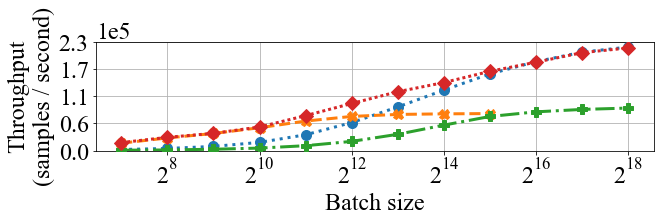

<Figure size 360x72 with 0 Axes>

In [847]:
plot_throughput_vs_batch_size(
    "mlp-small",
    "~/Downloads/pure_baselines/mlp-small_backend_dp.csv",
    "~/Downloads/pure_baselines/mlp-small_backend_hp.csv",
    "~/Downloads/pure_baselines/mlp-small_backend_pp.csv",
    "~/Downloads/mlp_dgx_simulated_grid_search_results_best_v2.csv",
    "~/Downloads/mlp_dgx_backend_grid_search_results_best_v2.csv",
    output_filename=os.path.join(FIGURES_DIR, "mlp-small_automatic_distribution.pdf"),
    legend_output_filename=os.path.join(FIGURES_DIR, "automatic_distribution_legend.pdf"),
    max_batch_size=524288,
)

[128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
& 128 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.1$\times$ & 43.8$\times$ \\
& 256 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & 35.3$\times$ \\
& 512 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & 22.4$\times$ \\
& 1024 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & 15.6$\times$ \\
& 2048 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & 10.0$\times$ \\
& 4096 & 2\ /\ 8\ /\ 1\ /\ 1 & - & 1.1$\times$ & 6.1$\times$ \\
& 8192 & 4\ /\ 4\ /\ 1\ /\ 1 & - & 1.2$\times$ & 3.7$\times$ \\
& 16384 & 4\ /\ 4\ /\ 1\ /\ 1 & - & - & 2.4$\times$ \\
& 32768 & 2\ /\ 4\ /\ 2\ /\ 8 & - & - & 1.5$\times$ \\
& 65536 & 4\ /\ 2\ /\ 2\ /\ 8 & - & - & 1.3$\times$ \\
& 131072 & 4\ /\ 2\ /\ 2\ /\ 32 & - & - & - \\


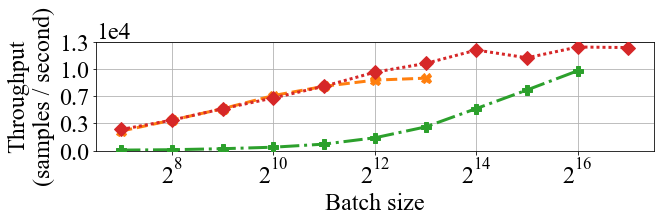

<Figure size 360x72 with 0 Axes>

In [848]:
plot_throughput_vs_batch_size(
    "mlp-medium",
    "",
    "~/Downloads/pure_baselines/mlp-medium_backend_hp.csv",
    "~/Downloads/pure_baselines/mlp-medium_backend_pp.csv",
    "~/Downloads/mlp_dgx_simulated_grid_search_results_best_v2.csv",
    "~/Downloads/mlp_dgx_backend_grid_search_results_best_v2.csv",
    output_filename=os.path.join(FIGURES_DIR, "mlp-medium_automatic_distribution.pdf"),
)

[128, 256, 512, 1024]
& 128 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & 61.7$\times$ \\
& 256 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & - \\
& 512 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & - \\
& 1024 & 1\ /\ 16\ /\ 1\ /\ 1 & - & 1.0$\times$ & - \\


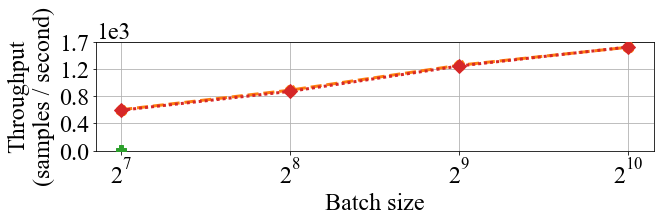

<Figure size 360x72 with 0 Axes>

In [849]:
plot_throughput_vs_batch_size(
    "mlp-large",
    "",
    "~/Downloads/pure_baselines/mlp-large_backend_hp.csv",
    "~/Downloads/pure_baselines/mlp-large_backend_pp.csv",
    "~/Downloads/mlp_dgx_simulated_grid_search_results_best_v2.csv",
    "~/Downloads/mlp_dgx_backend_grid_search_results_best_v2.csv",
    output_filename=os.path.join(FIGURES_DIR, "mlp-large_automatic_distribution.pdf"),
    max_batch_size=2048
)

[128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
& 32768\ /\ 16\ /\ 1\ /\ 1\ /\ 1 & 1.0$\times$ & 3.7$\times$ & 2.9$\times$ \\


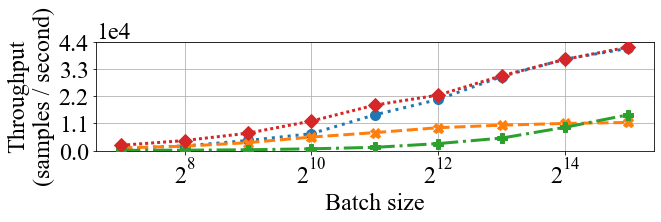

<Figure size 360x72 with 0 Axes>

In [853]:
plot_throughput_vs_batch_size(
    "gpt3-xl",
    "~/Downloads/pure_baselines/gpt3-xl_backend_dp.csv",
    "~/Downloads/pure_baselines/gpt3-xl_backend_hp.csv",
    "~/Downloads/pure_baselines/gpt3-xl_backend_pp.csv",
    "~/Downloads/gpt2_dgx_simulated_grid_search_results_best_v2.csv",
    "~/Downloads/gpt2_dgx_backend_grid_search_results_best_v2.csv",
    output_filename=os.path.join(FIGURES_DIR, "gpt3-xl_automatic_distribution.pdf"),
    fixed_batch_size=False,
    max_batch_size=65536,
)

[128, 256, 512, 1024, 2048, 4096, 8192, 16384]
& 16384\ /\ 16\ /\ 1\ /\ 1\ /\ 1 & 1.0$\times$ & 2.6$\times$ & 2.0$\times$ \\


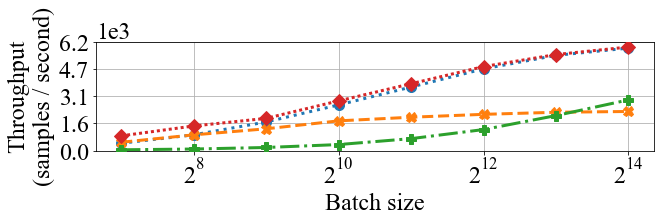

<Figure size 360x72 with 0 Axes>

In [854]:
plot_throughput_vs_batch_size(
    "gpt3-13B",
    "~/Downloads/pure_baselines/gpt3-13B_backend_dp.csv",
    "~/Downloads/pure_baselines/gpt3-13B_backend_hp.csv",
    "~/Downloads/pure_baselines/gpt3-13B_backend_pp.csv",
    "~/Downloads/gpt2_dgx_simulated_grid_search_results_best_v2.csv",
    "~/Downloads/gpt2_dgx_backend_grid_search_results_best_v2.csv",
    output_filename=os.path.join(FIGURES_DIR, "gpt3-13B_automatic_distribution.pdf"),
    fixed_batch_size=False,
    max_batch_size = 32768,
)

[128, 256, 512, 1024]
& 1024\ /\ 1\ /\ 8\ /\ 2\ /\ 2 & - & 1.3$\times$ & 5.6$\times$ \\


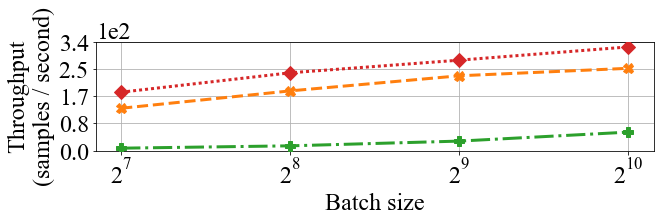

<Figure size 360x72 with 0 Axes>

In [855]:
plot_throughput_vs_batch_size(
    "gpt3-175B",
    "",
    "~/Downloads/pure_baselines/gpt3-175B_backend_hp.csv",
    "~/Downloads/pure_baselines/gpt3-175B_backend_pp.csv",
    "~/Downloads/gpt2_dgx_simulated_grid_search_results_best_v2.csv",
    "~/Downloads/gpt2_dgx_backend_grid_search_results_best_v2.csv",
    output_filename=os.path.join(FIGURES_DIR, "gpt3-175B_automatic_distribution.pdf"),
    fixed_batch_size=False,
    max_batch_size=2048
)

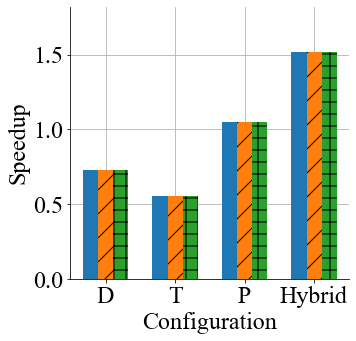

<Figure size 360x72 with 0 Axes>

In [696]:
pytorch_filename = "~/Downloads/mlp_grid_search_results_pytorch_v100.csv"
plot_optimal_configurations(
    pytorch_filename,
    ["mlp-xs", "mlp-small", "mlp-medium"],
    "throughput",
    os.path.join(FIGURES_DIR, "mlp_training_optimal_configurations.pdf"),
    os.path.join(FIGURES_DIR, "mlp_training_optimal_configurations_legend.pdf"),
)

### GPT-2 Inference

### TODO

## Memory usage vs throughput / latency

In [562]:
def plot_memory_usage_vs_metric(
    simulation_filename,
    model_size,
    min_batch_size,
    metric,
    xlabel,
    ylabel,
    output_filename,
    legend_output_filename=None,
    batch_size=None,
):
    plt.rc('xtick', labelsize=24)
    plt.rc('ytick', labelsize=24)
    plt.rc('axes', labelsize=24)
    df = pd.read_csv(simulation_filename)
    df = df[df["model_size"] == model_size]
    df = df[df["peak_memory"] <= 32 * 1e9]
    df = df[df["batch_size"] >= (min_batch_size / 2)]
    print(f"Max batch size: {max(df['batch_size'].unique())}")
    if batch_size is not None:
        df = df[df["batch_size"] == batch_size]
    parallelism_styles = [
        get_parallelism_style(dp, hp, pp)
        for (dp, hp, pp) in df[["dp_degree", "hp_degree", "pp_degree"]].values
    ]
    df["parallelism_style"] = parallelism_styles
    markers = ["o", "P", "^", "*", "X", "D", "H", "s"]
    colors = [
        "#1f77b4",  # muted blue
        "#ff7f0e",  # safety orange
        "#2ca02c",  # cooked asparagus green
        "#d62728",  # brick red
        "#9467bd",  # muted purple
        "#8c564b",  # chestnut brown
        "#e377c2",  # raspberry yogurt pink
        "#7f7f7f",  # middle gray
        # "#bcbd22",  # curry yellow-green
        # "#17becf",  # blue-teal
    ]
    parallelism_styles = [
        "D",
        "T",
        "P",
        "D/T",
        "T/P",
        "D/P",
        "D/T/P",
    ]
    lines = []
    fig = pylab.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    figlegend = pylab.figure(figsize=(5, 1))
    for (parallelism_style, marker, color) in zip(parallelism_styles, markers, colors):
        lines.append(
            ax.scatter(
                df[df["parallelism_style"] == parallelism_style][metric],
                df[df["parallelism_style"] == parallelism_style]["peak_memory"] / 1e9,
                label=parallelism_style,
                marker=marker,
                color=color,
                s=200,
                zorder=3,
            )
        )
    ax.grid(zorder=0)
    ax.set_ylim(0, 32)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    fig.savefig(output_filename, bbox_inches="tight")
    leg = figlegend.legend(
        lines,
        parallelism_styles,
        frameon=False,
        loc="center",
        ncol=8,
        columnspacing=None,
        labelspacing=None,
    )
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")

### MLP Training

Max batch size: 1048576


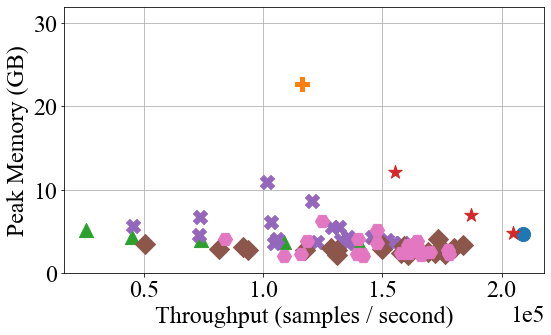

<Figure size 360x72 with 0 Axes>

In [689]:
simulation_filename = "~/Downloads/mlp_dgx_simulated_grid_search_results_v2.csv"
plot_memory_usage_vs_metric(
    simulation_filename,
    "mlp-small",
    0,
    "throughput",
    "Throughput (samples / second)",
    "Peak Memory (GB)",
    os.path.join(FIGURES_DIR, "mlp-small_memory_vs_throughput.pdf"),
    os.path.join(FIGURES_DIR, "mlp_training_memory_vs_throughput_legend.pdf"),
    65536,
)

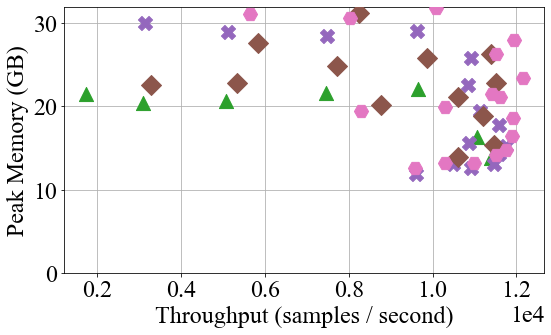

<Figure size 360x72 with 0 Axes>

In [555]:
simulation_filename = "~/Downloads/mlp_dgx_simulated_grid_search_results_v2.csv"
plot_memory_usage_vs_metric(
    simulation_filename,
    "mlp-medium",
    0,
    "throughput",
    "Throughput (samples / second)",
    "Peak Memory (GB)",
    os.path.join(FIGURES_DIR, "mlp-medium_memory_vs_throughput.pdf"),
    None,
    65536,
)

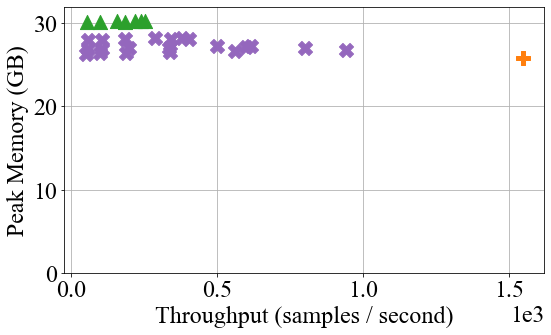

<Figure size 360x72 with 0 Axes>

In [543]:
simulation_filename = "~/Downloads/mlp_dgx_simulated_grid_search_results_v2.csv"
plot_memory_usage_vs_metric(
    simulation_filename,
    "mlp-large",
    0,
    "throughput",
    "Throughput (samples / second)",
    "Peak Memory (GB)",
    os.path.join(FIGURES_DIR, "mlp-large_memory_vs_throughput.pdf"),
    None,
    256,
)

### GPT-2 Inference

Max batch size: 1048576


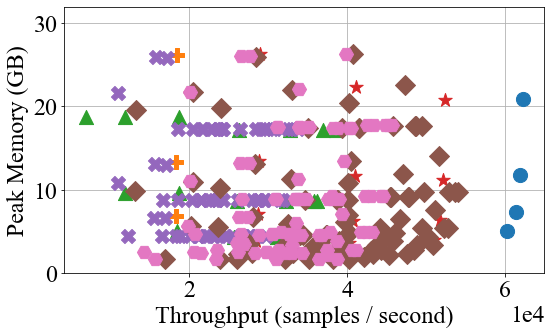

<Figure size 360x72 with 0 Axes>

In [563]:
simulation_filename = "~/Downloads/gpt2_dgx_simulated_grid_search_results.csv"
plot_memory_usage_vs_metric(
    simulation_filename,
    "gpt3-xl",
    131072,
    "throughput",
    "Throughput (samples / second)",
    "Peak Memory (GB)",
    os.path.join(FIGURES_DIR, "gpt3-xl_memory_vs_throughput.pdf"),
    None,
)

Max batch size: 524288


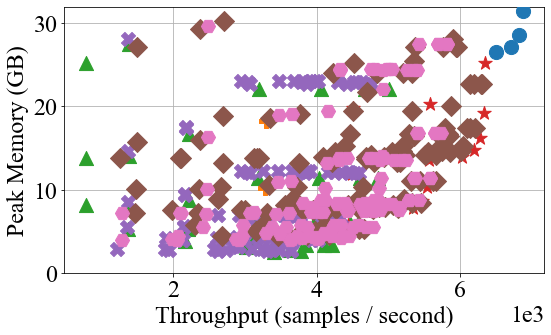

<Figure size 360x72 with 0 Axes>

In [564]:
simulation_filename = "~/Downloads/gpt2_dgx_simulated_grid_search_results.csv"
plot_memory_usage_vs_metric(
    simulation_filename,
    "gpt3-13B",
    16384,
    "throughput",
    "Throughput (samples / second)",
    "Peak Memory (GB)",
    os.path.join(FIGURES_DIR, "gpt3-13B_memory_vs_throughput.pdf"),
    None,
)

Max batch size: 32768


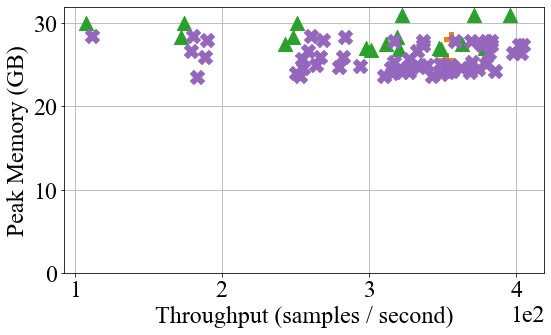

<Figure size 360x72 with 0 Axes>

In [565]:
simulation_filename = "~/Downloads/gpt2_dgx_simulated_grid_search_results.csv"
plot_memory_usage_vs_metric(
    simulation_filename,
    "gpt3-175B",
    8192,
    "throughput",
    "Throughput (samples / second)",
    "Peak Memory (GB)",
    os.path.join(FIGURES_DIR, "gpt3-175B_memory_vs_throughput.pdf"),
    None,
)

## Simulator Scalability

In [570]:
def plot_scalability_metric(
    filename,
    x1,
    x1_order,
    x1_order_labels,
    x2,
    y,
    xlabel,
    yticks,
    output_filename,
):
    plt.rc("xtick", labelsize=20)
    plt.rc("ytick", labelsize=20)
    plt.rc("axes", labelsize=20)
    plt.figure(figsize=(8, 3))
    df = pd.read_csv(filename)
    markers = ["o", "P", "^", "*", "X", "D", "H", "s"]
    linestyles = ["solid", "dotted", "dashed", "dashdot", (0, (5, 1))]
    markersize = 10
    linewidth = 3
    lines = []
    for i, (v, label) in enumerate(zip(x1_order, x1_order_labels)):
        x_ = df[df[x1] == v][x2]
        y_ = df[df[x1] == v][y]
        lines.append(
            plt.plot(
                x_,
                y_,
                marker=markers[i],
                label=label,
                linestyle=linestyles[i],
                linewidth=linewidth,
                markersize=markersize,
            )[0]
        )
    plt.xlabel(xlabel)
    plt.ylabel("Simulation time\n(seconds)")
    plt.tight_layout()
    plt.grid()
    leg = plt.figlegend(
        lines, x1_order_labels, loc="lower center", ncol=len(x1_order_labels)
    )
    # Get the bounding box of the original legend.
    bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())
    # Change to location of the legend.
    yOffset = 1.6
    bb.y0 += yOffset
    bb.y1 += yOffset
    leg.set_bbox_to_anchor(bb, transform=plt.gca().transAxes)
    leg.get_frame().set_linewidth(0.0)
    plt.savefig(output_filename, bbox_inches="tight")

In [757]:
def plot_time_vs_op_count(filename, output_filename):
    plt.figure(figsize=(8, 3))
    df = pd.read_csv(filename)
    x = df["op_count"]
    y = df["simulate_runtime"]
    m, b = np.polyfit(x, y, deg=1)
    plt.scatter(x, y, zorder=2)
    plt.plot(
        x,
        m * x + b,
        linestyle="--",
        color="black",
        zorder=1,
    )
    plt.tight_layout()
    plt.grid()
    plt.xlabel("Op Count")
    plt.ylabel("Simulation time\n(seconds)")
    plt.yticks([50, 150, 250, 350])
    plt.savefig(output_filename, bbox_inches="tight")

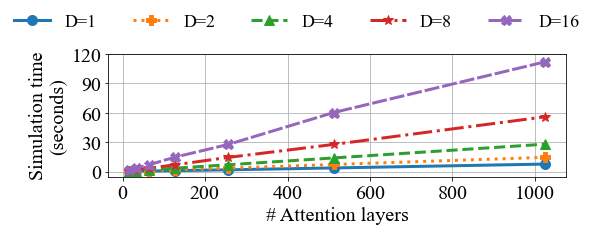

In [407]:
filename = "~/Downloads/time_vs_n_layer.csv"
plot_scalability_metric(
    filename,
    "degree",
    [1, 2, 4, 8, 16],
    ["D=1", "D=2", "D=4", "D=8", "D=16"],
    "n_layer",
    "simulate_runtime",
    "# Attention layers",
    [0, 30, 60, 90, 120],
    os.path.join(FIGURES_DIR, "time_vs_n_layer.pdf"),
)

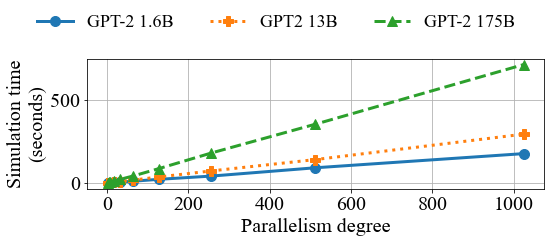

In [571]:
filename = "~/Downloads/time_vs_device_count.csv"
plot_scalability_metric(
    filename,
    "model_size",
    ["gpt3-xl", "gpt3-13B", "gpt3-175B"],
    ["GPT-2 1.6B", "GPT2 13B", "GPT-2 175B"],
    "degree",
    "simulate_runtime",
    "Parallelism degree",
    [0, 200, 400, 600, 800],
    os.path.join(FIGURES_DIR, "time_vs_device_count.pdf"),
)

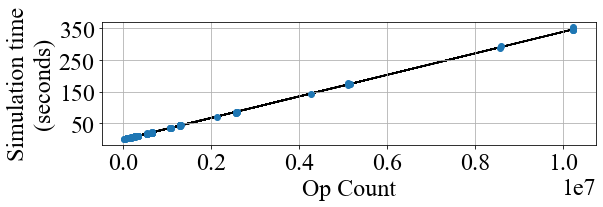

In [759]:
filename = "~/Downloads/time_vs_op_count.csv"
plot_time_vs_op_count(filename, os.path.join(FIGURES_DIR, "time_vs_op_count.pdf"))